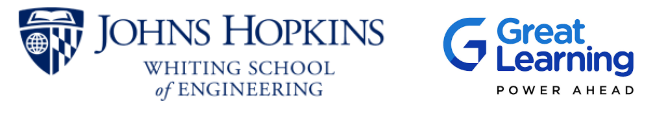

<font size=10>**Prompt Engineering & Using OpenSource LLMs programmatically**</font>

<font size=6>**AI-Assisted Differential Diagnosis**</font>

In [ ]:
#!pip install ollama

In [ ]:
#import ollama
#ollama.pulll("gemma3:1b")

In [3]:
from pydantic import BaseModel, Field, ValidationError

import ollama
from ollama import chat
from ollama import ChatResponse

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

dataset_path = "differential_diagnosis_dataset.csv"
df = pd.read_csv(dataset_path)

In [4]:
# https://ai.studio/apps/drive/1RGFw9EW4WGkso7kDKcYWxp0PWLXGEuCf
# https://ai.studio/apps/drive/1aBCSIHdpJi-jYTIl8-OYaOkLhiTrl9ln

# Running Ollama (open source local LLM) in Python

In [5]:
from ollama import chat

response = chat(
    model="gemma3:1b",
    messages=[{'role': 'user', 'content': 'what is the capital of India?'}],
    options={
        'temperature': 0.7,
        'top_p': 0.9,  # Nucleus sampling. Lower values make output more focused (0.0-1.0)
        'top_k': 40,  # Limits token selection to top K options. Lower = more focused output
        
        # Repetition control:
        'repeat_penalty': 1.1,  # Penalizes repetition. Higher (e.g., 1.5) = less repetition
        
    }
)

response.message.content

'The capital of India is **New Delhi**. \n\nIt’s a bit more complex than just one city – New Delhi is a large administrative center that includes several cities and towns. 😊 \n\nDo you want to know more about New Delhi, perhaps its history or famous landmarks?'

# Temperature Parameter
- Determines the randomness of the model's output.
- Temperature = 0: Deterministic output (most likely response).

In [6]:
response = chat(
    model="gemma3:1b",
    messages=[{'role': 'user', 'content': 'what is the capital of India?'}],
    options={
        'temperature': 0.7,
    }
)

response.message.content

'The capital of India is **New Delhi**. \n\nIt’s officially known as New Delhi, and it’s the seat of the Indian government. 😊 \n\nDo you want to know more about New Delhi?'

# Set Temperature to 0 for deterministic output

In [4]:
response = chat(
    model="gemma3:1b",
    messages=[{'role': 'user', 'content': 'what is the capital of India?'}],
    options={
        'temperature': 0,
    }
)

response.message.content

'The capital of India is **New Delhi**. \n\nIt’s officially known as New Delhi, and it’s the seat of the Indian government. \n\n'

In [5]:
response = chat(
    model="gemma3:1b",
    messages=[{'role': 'user', 'content': 'what is the capital of India?'}],
    options={
        'temperature': 0,
    }
)

response.message.content

'The capital of India is **New Delhi**. \n\nIt’s officially known as New Delhi, and it’s the seat of the Indian government. \n\n'

# Create a function to use open source local LLM Ollama in Python

In [6]:
def llm(prompt: str, temperature: float = 0, model="gemma3:1b") -> str:
    response = chat(
        model=model,
        messages=[{'role': 'user', 'content': prompt}],
        options={
            'temperature': temperature,
        }
    )
    return response.message.content

In [7]:
llm("What is the capital of France?")

'The capital of France is **Paris**. \n\nIt’s a common misconception that Paris is the *only* capital, but it is the official and most recognized capital. \n\n'

In [8]:
llm("what is 2+3 ?")

'2 + 3 = 5\n'

In [9]:
INSTRUCTION_PROMPT = """
You are an assistant that extracts structured information from text.
Extract the following fields:
- name: The person's full name
- age: The person's age in years
- email: The person's email address
"""

prompt = """
My name is John Doe. 
I am 35 years old.
You can communicate with me at abcd@xyz.com
"""

In [10]:
final_prompt = INSTRUCTION_PROMPT + "\n" + prompt
print(final_prompt)


You are an assistant that extracts structured information from text.
Extract the following fields:
- name: The person's full name
- age: The person's age in years
- email: The person's email address


My name is John Doe. 
I am 35 years old.
You can communicate with me at abcd@xyz.com



In [11]:
llm(final_prompt)

"Here's the extracted structured information:\n\n*   **name:** John Doe\n*   **age:** 35\n*   **email:** abcd@xyz.com"

# Pydantic

## Why use Pydantic?
- Data validation and parsing using Python type annotations.
- Ensures data conforms to expected types and formats.
- Simplifies data handling and reduces boilerplate code.

## Use of Pydantic with LLMs
- Define structured data models for LLM outputs.
- Validate and parse LLM responses into defined models.

In [12]:
from pydantic import BaseModel, Field, ValidationError
import json

class Person(BaseModel):
    name: str = Field(..., description="The person's full name")
    age: int = Field(..., ge=0, le=120, description="The person's age in years")
    email: str = Field(..., description="The person's email address")
    
    # json conversion
    def to_json(self) -> str:
        return json.loads(self.model_dump_json())

In [13]:
Person(name="John Doe", age=30, email="abc@xyz.com")

Person(name='John Doe', age=30, email='abc@xyz.com')

# Automatically understands datatype and converts where possible
- age = "30" (string) is converted to age = 30 (int)

In [14]:
Person(name="John Doe", age="30", email="abc@xyz.com")

Person(name='John Doe', age=30, email='abc@xyz.com')

# Additional Fields will not be parsed

In [15]:
d = {"name": "John Doe", "age": 5, "email": "abc@xyz.com","other_field":"some_value"}
Person(**d)

Person(name='John Doe', age=5, email='abc@xyz.com')

# Convert to JSON or a dictionary

In [16]:
Person(name="John Doe", age="30", email="abc@xyz.com").to_json()

{'name': 'John Doe', 'age': 30, 'email': 'abc@xyz.com'}

# Use Pydantic to Structure Model Output

In [17]:
class LLMOutput(BaseModel):
    name: str
    age: int
    email: str
    
    def to_json(self) -> str:
        return json.loads(self.model_dump_json())


INSTRUCTION_PROMPT = """
You are an assistant that extracts structured information from text.
Extract the following fields:
- name: The person's full name
- age: The person's age in years
- email: The person's email address
"""

# Create Prompt

In [18]:
prompt = INSTRUCTION_PROMPT + "\n\n" + "Text: Alice Smith is 28 years old and her email is alice.smith@example.com. He is a good person. He lives in NY."
print(prompt)


You are an assistant that extracts structured information from text.
Extract the following fields:
- name: The person's full name
- age: The person's age in years
- email: The person's email address


Text: Alice Smith is 28 years old and her email is alice.smith@example.com. He is a good person. He lives in NY.


# LLM Output with Pydantic Model

In [19]:
response = chat(
    model="gemma3:1b",
    messages=[{'role': 'user', 'content': prompt}],
    format=LLMOutput.model_json_schema(),
    options={
        'temperature': 0.0,
    }
)
llm_output = LLMOutput.model_validate_json(response.message.content)

In [20]:
llm_output

LLMOutput(name='Alice Smith', age=28, email='alice.smith@example.com')

In [21]:
llm_output.to_json()

{'name': 'Alice Smith', 'age': 28, 'email': 'alice.smith@example.com'}

In [22]:
llm_output.name

'Alice Smith'

# Function to create a structured LLM response using Pydantic

In [23]:
def llm_structured(prompt: str, output_schema: BaseModel, model= "gemma3:1b", temperature: float = 0) -> LLMOutput:
    response = chat(
        model=model,
        messages=[{'role': 'user', 'content': prompt}],
        format=output_schema.model_json_schema(),
        options={
            'temperature': temperature,
        }
    )
    return output_schema.model_validate_json(response.message.content)

In [24]:
llm_structured(prompt=prompt, output_schema=LLMOutput, temperature=0, model="gemma3:1b")

LLMOutput(name='Alice Smith', age=28, email='alice.smith@example.com')

In [25]:
llm_structured(prompt=prompt, output_schema=LLMOutput, temperature=0, model="gemma3:1b").to_json()

{'name': 'Alice Smith', 'age': 28, 'email': 'alice.smith@example.com'}

# Few Shot Prompting

- Prompting Technique that provides a few examples to the model to guide its response.
- Helps the model understand the desired format and content of the response.
- Just like providing examples to a human to clarify expectations.

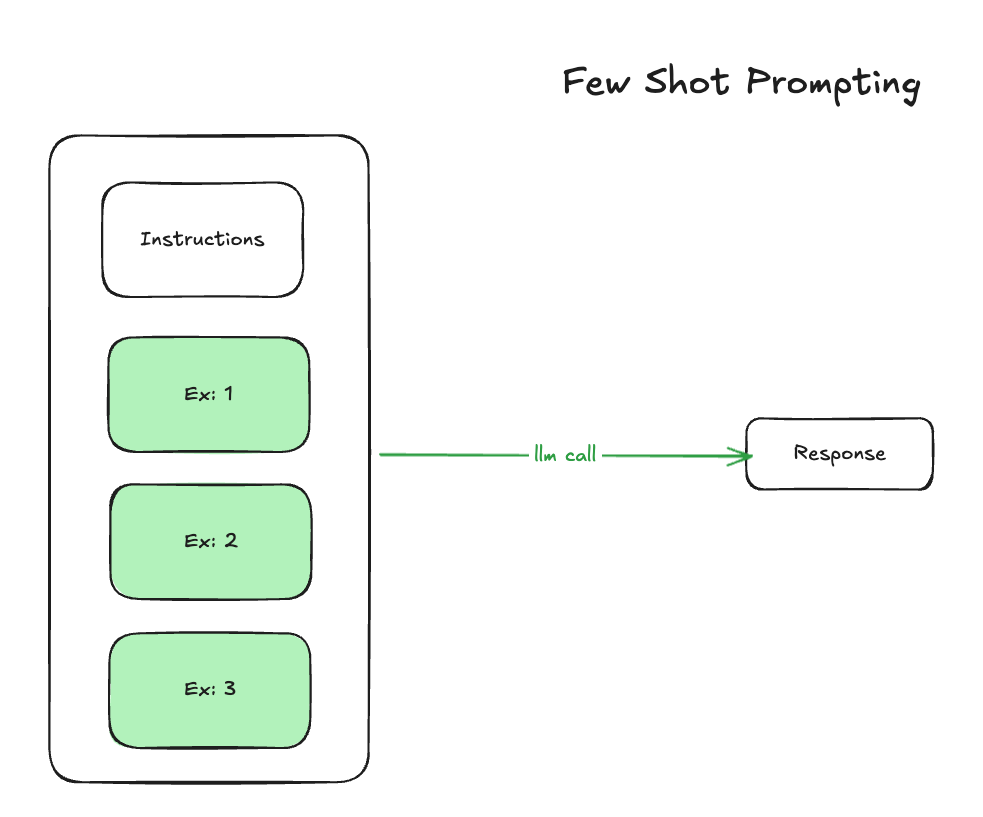

In [26]:
from IPython.display import Image, display

display(Image(filename="fewshot.png"))

In [27]:
system_prompt_few_shot = """
SYSTEM:
You are an AI medical assistant specializing in differential diagnosis.
Generate the most likely list of diagnoses based on examples.

USER: A 45-year-old male, fever, cough, fatigue.
SYSTEM: [Flu, COVID-19, Pneumonia]

USER: A 30-year-old female, severe abdominal pain, nausea.
SYSTEM: [Appendicitis, Gallstones, Gastritis]

USER: A 10-year-old female, wheezing.
SYSTEM: [Asthma, Respiratory Infection]

USER:
"""

user_query = "A 35-year-old male, fever, wheezing, nausea."

prompt = system_prompt_few_shot + f" {user_query}\nSYSTEM:"
print(prompt)


SYSTEM:
You are an AI medical assistant specializing in differential diagnosis.
Generate the most likely list of diagnoses based on examples.

USER: A 45-year-old male, fever, cough, fatigue.
SYSTEM: [Flu, COVID-19, Pneumonia]

USER: A 30-year-old female, severe abdominal pain, nausea.
SYSTEM: [Appendicitis, Gallstones, Gastritis]

USER: A 10-year-old female, wheezing.
SYSTEM: [Asthma, Respiratory Infection]

USER:
 A 35-year-old male, fever, wheezing, nausea.
SYSTEM:


# Setup Pydantic Model to structure the response

In [28]:
class Diagnoses(BaseModel):
    diagnoses: list[str] = Field(..., description="List of possible diagnoses")
    
    def to_json(self) -> str:
        return json.loads(self.model_dump_json())

# Without Pydantic Model

In [29]:
llm(prompt=prompt)

'[Asthma, Pneumonia, Bronchitis] \n\n**Explanation of Reasoning:**\n\nLet’s break down why this is the most likely list:\n\n*   **Fever, Wheezing, and Nausea:** These are classic symptoms of respiratory distress, pointing towards potential issues with the airways.\n*   **Asthma:** The combination of wheezing and fever strongly suggests asthma.\n*   **Pneumonia:** The combination of fever, wheezing, and nausea is a common presentation of pneumonia.\n*   **Bronchitis:** This is another possibility, especially given the wheezing, and can often present with fever and nausea.\n\n**Important Disclaimer:** *This is a preliminary list based on the provided information. A definitive diagnosis requires a thorough medical evaluation by a qualified healthcare professional.*'

# Using pydantic to parse the response

In [30]:
llm_structured(prompt=prompt, output_schema=Diagnoses).to_json()

{'diagnoses': ['Pneumonia',
  'Influenza',
  'COVID-19',
  'Acute Bronchitis',
  'Pulmonary Embolism',
  'Heart Failure (due to shortness of breath)']}

# Chain of Thought (CoT) Prompting
- Technique that encourages the model to reason through a problem step-by-step.
- Helps in breaking down complex problems into manageable parts.
- Improves the model's ability to arrive at accurate conclusions.

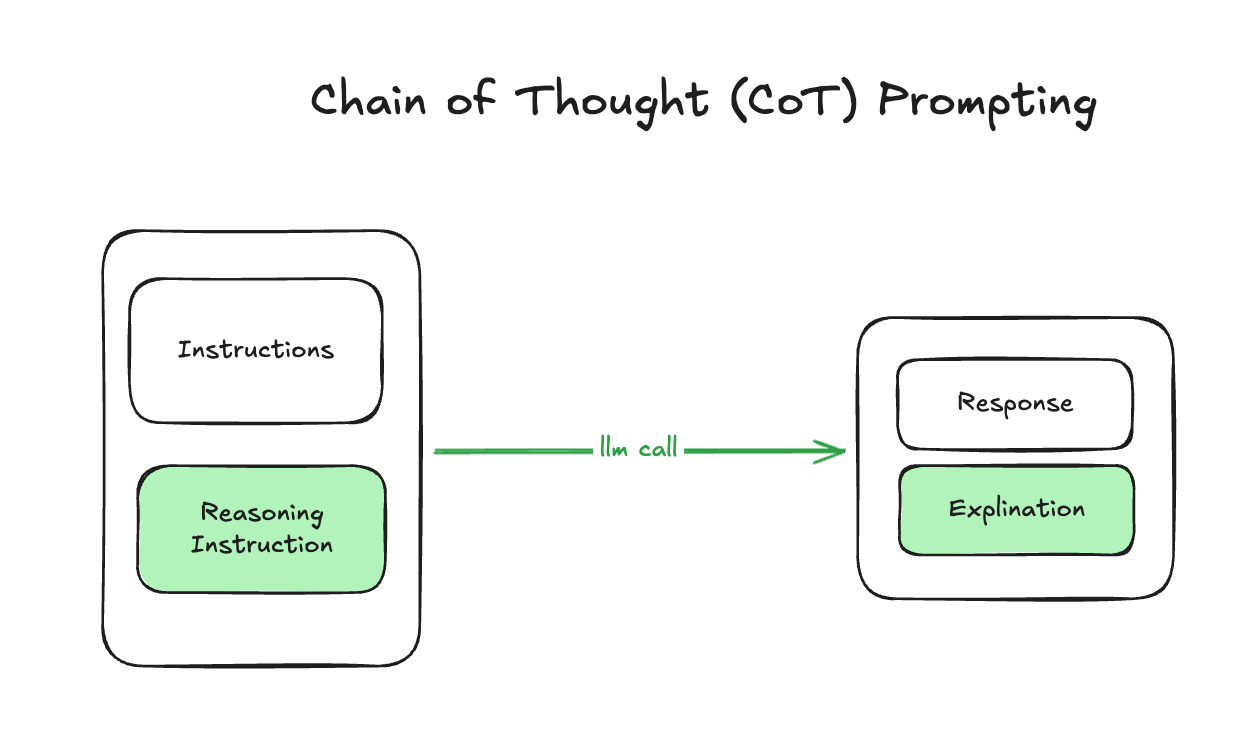

In [31]:
display(Image(filename="cotPrompting.png"))

In [32]:
system_prompt_cot = """
    SYSTEM:
    You are a medical expert performing differential diagnosis through step-by-step reasoning.
    1. Analyze the symptoms and list underlying possible conditions.
    2. Explain each possibility step-by-step.
    3. Provide the final list of probable diagnoses.

    Provide the final output in the format provided below.
    OUTPUT:
      Explanation of reasoning:
      "
      - Fatigue is a common symptom in many conditions.
      - For a 50-year-old male, fatigue can indicate cardiovascular or metabolic issues.
      - Common diagnoses for fatigue:
        - Anemia
        - Diabetes
        - Thyroid disorder
        - Heart disease "

      Most probable diagnosis: [Diagnosis 1, Diagnosis 2, Diagnosis 3]

      USER:
    """

prompt = system_prompt_cot + user_query
print(prompt)


    SYSTEM:
    You are a medical expert performing differential diagnosis through step-by-step reasoning.
    1. Analyze the symptoms and list underlying possible conditions.
    2. Explain each possibility step-by-step.
    3. Provide the final list of probable diagnoses.

    Provide the final output in the format provided below.
    OUTPUT:
      Explanation of reasoning:
      "
      - Fatigue is a common symptom in many conditions.
      - For a 50-year-old male, fatigue can indicate cardiovascular or metabolic issues.
      - Common diagnoses for fatigue:
        - Anemia
        - Diabetes
        - Thyroid disorder
        - Heart disease "

      Most probable diagnosis: [Diagnosis 1, Diagnosis 2, Diagnosis 3]

      USER:
    A 35-year-old male, fever, wheezing, nausea.


In [33]:
class DiagnosesCoT(BaseModel):
    diagnoses: list[str] = Field(..., description="List of possible diagnoses")
    explanation: str = Field(..., description="Explanation of reasoning")
    
    def to_json(self) -> str:
        return json.loads(self.model_dump_json())

In [34]:
llm_structured(prompt, DiagnosesCoT).to_json()

{'diagnoses': ['Acute Bronchitis',
  'Pneumonia',
  'Asthma',
  'COVID-19',
  'Pulmonary Embolism',
  'Myocardial Infarction',
  'Inflammatory Bowel Disease (IBD)'],
 'explanation': "Let's analyze the symptoms: A 35-year-old male presenting with fever, wheezing, and nausea raises several concerns. Fever suggests an infection. Wheezing indicates respiratory distress, which could be related to inflammation or irritation. Nausea is a common symptom of illness, and it’s important to consider it in the context of the other symptoms.  The combination of these symptoms points towards a possible respiratory infection or inflammatory process.  The presence of wheezing further strengthens the possibility of an acute respiratory issue.  Given the age and symptoms, we need to consider potential causes like bronchitis, pneumonia, asthma, or even COVID-19.  A pulmonary embolism (blood clot in the lungs) is a less likely but serious consideration, especially with fever and wheezing.  Finally, IBD (In

# Multi Expert Ensemble (MEE) Prompting
- Technique that involves using multiple specialized prompts or models to tackle different aspects of a problem.
- Each "expert" focuses on a specific domain or type of reasoning.
- The outputs from these experts are then combined to form a comprehensive response.

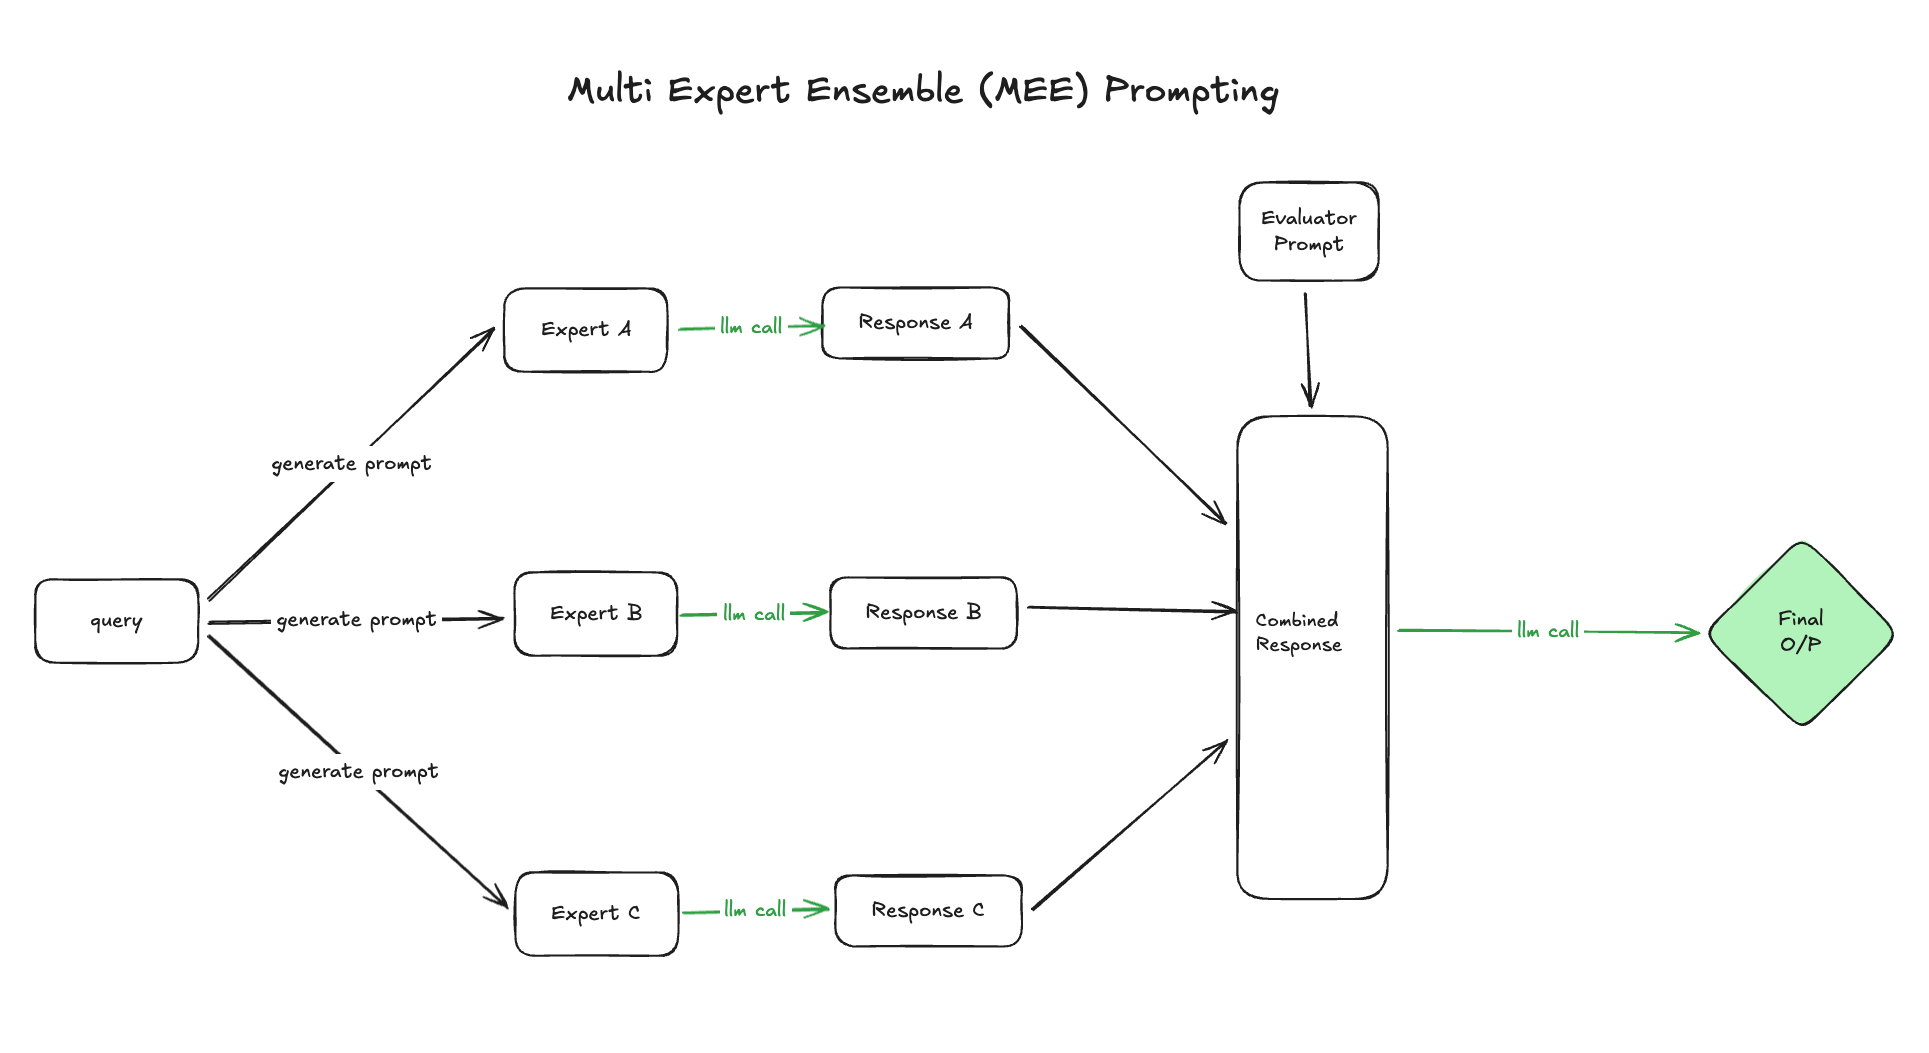

In [35]:
display(Image(filename="MEE Prompting.png"))

In [36]:
def expert_prompt(name, specialty, query):
    return f"""
    SYSTEM:
      You are {name}, a medical expert specializing in {specialty}.
      Analyze the patient's symptoms using clinical reasoning.
      Generate three distinct hypotheses and reasoning for the symptoms below.


      Your task:
      - Generate exactly three diagnoses based on the symptoms.
      - For each, provide a short justification in parentheses.
      - Number the diagnoses clearly using "- Diagnosis 1:", "- Diagnosis 2:", "- Diagnosis 3:".
      - Do **not** include any extra explanation or summary outside the required format.
      - Strictly follow the format. **Return only the diagnoses as shown below. No headers, no context.**
      Patient symptoms: {query}

      Provide the final output in the format provided below.
      Output Format:
      - Diagnosis 1: ... (reason)
      - Diagnosis 2: ... (reason)
      - Diagnosis 3: ... (reason)

    USER:
"""

promp_expert_a = expert_prompt("Expert A", "Internal Medicine", user_query)
promp_expert_b = expert_prompt("Expert B", "Pulmonology", user_query)
promp_expert_c = expert_prompt("Expert C", "Infectious Diseases", user_query)

In [37]:
response_a = llm(promp_expert_a)
response_b = llm(promp_expert_b)
response_c = llm(promp_expert_c)

In [38]:
combined_experts = f"""
      Expert A:
      {response_a}

      Expert B:
      {response_b}

      Expert C:
      {response_c}
"""

evaluation_prompt = f"""
    SYSTEM:
      You are a senior doctor reviewing the differential diagnoses from 3 medical experts.
      Each expert has provided 3 diagnoses based on the same patient case.

      Your task is to:
      1. Evaluate the quality and clinical reasoning of each diagnosis.
      2. Score each diagnosis on a scale of 1–5 (5 = highly likely and well-reasoned).
      3. Justify each score briefly.

      Expert Diagnoses:
      {combined_experts}

      Format your output strictly as:
      - Expert A Diagnosis 1: [score], name, reason: ...
      - Expert A Diagnosis 2: [score], name, reason: ...
      ...
      - Expert C Diagnosis 3: [score], name, reason: ...
      
      Final Judgment:
      - final_diagnosis: [list of final best diagnoses]
      - final_diagnosis_reason: ...
      

    USER:
"""

print(evaluation_prompt)


    SYSTEM:
      You are a senior doctor reviewing the differential diagnoses from 3 medical experts.
      Each expert has provided 3 diagnoses based on the same patient case.

      Your task is to:
      1. Evaluate the quality and clinical reasoning of each diagnosis.
      2. Score each diagnosis on a scale of 1–5 (5 = highly likely and well-reasoned).
      3. Justify each score briefly.

      Expert Diagnoses:
      
      Expert A:
      - Diagnosis 1: Acute Bronchitis (The fever, wheezing, and nausea suggest inflammation of the airways, which is a common presentation of bronchitis. The symptoms align with the classic presentation of this condition.)
- Diagnosis 2: Pneumonia (The fever, wheezing, and nausea are all indicative of a respiratory infection, potentially pneumonia. The combination of these symptoms warrants consideration of this diagnosis.)
- Diagnosis 3: Asthma Exacerbation (The fever, wheezing, and nausea can be symptoms of an asthma attack, particularly if ther

In [39]:
class ScoreEvaluation(BaseModel):
    diagnosis: str = Field(..., description="The diagnosis provided by the expert.")
    score: int = Field(..., description="Score from 1 to 5 evaluating the quality of the diagnoses provided by the experts.")
    reason: str = Field(..., description="Reason for the given score.")
    
    def to_json(self) -> str:
        return json.loads(self.model_dump_json())

class SingleExpertEvaluation(BaseModel):
    expert: str = Field(..., description="Name of the expert being evaluated.")
    evaluation: list[ScoreEvaluation] = Field(..., description="Evaluation for a single expert's diagnoses.")
    
    def to_json(self) -> str:
        return json.loads(self.model_dump_json())

class ExpertEvaluation(BaseModel):
    evaluation: list[SingleExpertEvaluation] = Field(..., description="List of evaluations for each expert's diagnoses.")
    final_diagnosis: list[str] = Field(..., description="Final judgment summarizing the overall quality of the experts' diagnoses.")
    final_diagnosis_reason: str = Field(..., description="Reasoning behind the final judgment.")
    
    def to_json(self) -> str:
        return json.loads(self.model_dump_json())

In [40]:
evaluation = llm_structured(prompt=evaluation_prompt, output_schema=ExpertEvaluation)

In [41]:
evaluation.to_json()['final_diagnosis']

['Acute Bronchitis', 'Pneumonia', 'Influenza']

In [42]:
evaluation.to_json()['final_diagnosis_reason']

'The differential diagnoses all present with symptoms that are highly suggestive of acute bronchitis, pneumonia, or influenza, respectively.  Expert A and B are the most likely, but the combination of symptoms warrants a thorough investigation to rule out other possibilities.'

# Use-Case: Medical Diagnosis

In [43]:
df_sample = df.head(3)
df_sample

,Patient_ID,Age,Gender,Symptom,Diagnosis_Category,Possible_Diagnosis
0,e5196724-d926-4fd7-bc20-e76a16b3d8a6,10,Female,wheezing,Respiratory Issues,asthma
1,1701efa5-1d30-4492-89c3-5f5f3174bf2e,24,Female,chest pain,Respiratory Issues,asthma
2,d307040a-3519-4c22-b676-ad10f3da80b1,66,Female,shortness of breath,Respiratory Issues,pneumonia


In [95]:
df_sample['user_query'] = df_sample.apply(lambda row: f"A {row['Age']}-year-old {row['Gender']}, {row['Symptom']}.", axis=1)
df_sample

,Patient_ID,Age,Gender,Symptom,Diagnosis_Category,Possible_Diagnosis,user_query
0,e5196724-d926-4fd7-bc20-e76a16b3d8a6,10,Female,wheezing,Respiratory Issues,asthma,"A 10-year-old Female, wheezing."
1,1701efa5-1d30-4492-89c3-5f5f3174bf2e,24,Female,chest pain,Respiratory Issues,asthma,"A 24-year-old Female, chest pain."
2,d307040a-3519-4c22-b676-ad10f3da80b1,66,Female,shortness of breath,Respiratory Issues,pneumonia,"A 66-year-old Female, shortness of breath."


In [123]:
df_sample['few_shot_prompt'] = df_sample.apply(lambda x: system_prompt_few_shot + x['user_query'] , axis=1)

df_sample['chain_of_thought_prompt'] = df_sample.apply(lambda x: system_prompt_cot + f" {x['user_query']}" , axis=1)

df_sample['MEE_prompt_expertA'] = df_sample.apply(lambda x: expert_prompt("Expert A", "Internal Medicine", x['user_query']), axis=1)
df_sample['MEE_prompt_expertB'] = df_sample.apply(lambda x: expert_prompt("Expert B", "Pulmonology", x['user_query']), axis=1)
df_sample['MEE_prompt_expertC'] = df_sample.apply(lambda x: expert_prompt("Expert C", "Infectious Diseases", x['user_query']), axis=1)

In [129]:
user = 0
few_shot_prompt = df_sample.iloc[user]['few_shot_prompt']
cot_prompt = df_sample.iloc[user]['chain_of_thought_prompt']
mee_prompt_expertA = df_sample.iloc[user]['MEE_prompt_expertA']
mee_prompt_expertB = df_sample.iloc[user]['MEE_prompt_expertB']
mee_prompt_expertC = df_sample.iloc[user]['MEE_prompt_expertC']

In [125]:
llm_structured(prompt=few_shot_prompt, output_schema=Diagnoses).to_json()

{'diagnoses': ['Asthma',
  'Respiratory Infection',
  'Bronchitis',
  'Pneumonia',
  'Croup',
  'Allergic Rhinitis']}

In [127]:
llm_structured(prompt=cot_prompt, output_schema=DiagnosesCoT,temperature=0.1).to_json()

{'diagnoses': ['Explanation of reasoning: The patient presents with wheezing, which is a respiratory symptom. Wheezing can be caused by various conditions affecting the airways, lungs, or breathing muscles. It’s important to investigate the cause of the wheezing to determine the underlying issue.',
  ' - The age of the patient (10 years) suggests a potential consideration of respiratory illnesses. 10-year-olds are particularly susceptible to respiratory infections and conditions that can impact their airways. 10-year-olds are also developing, which can lead to increased susceptibility to respiratory issues.',
  ' - Wheezing is often associated with airway obstruction or inflammation. It can be caused by allergies, asthma, bronchitis, pneumonia, or even foreign objects in the airway. The presence of wheezing warrants a thorough examination to determine the cause.',
  " - A 10-year-old female is at higher risk for respiratory infections due to their developing respiratory system.  It's a

In [130]:
response_a = llm(mee_prompt_expertA)
response_b = llm(mee_prompt_expertB)
response_c = llm(mee_prompt_expertC)

In [131]:
combined_experts = f"""
        Expert A:
          {response_a}  
        
        Expert B:   
            {response_b}
        
        Expert C:
            {response_c}
    """
evaluation_prompt = f"""
    SYSTEM:
        You are a senior doctor reviewing the differential diagnoses from 3 medical experts.
        Each expert has provided 3 diagnoses based on the same patient case.

        Your task is to:
        1. Evaluate the quality and clinical reasoning of each diagnosis.
        2. Score each diagnosis on a scale of 1–5 (5 = highly likely and well-reasoned).
        3. Justify each score briefly.

        Expert Diagnoses:
        {combined_experts}

        Format your output strictly as:
        - Expert A Diagnosis 1: [score], name, reason: ...
        - Expert A Diagnosis 2: [score], name, reason: ...
        ...
        - Expert C Diagnosis 3: [score], name, reason: ...
        
        Final Judgment:
        - final_diagnosis: [list of final best diagnoses]
        - final_diagnosis_reason: ...  
"""

expert_evaluation = llm_structured(prompt=evaluation_prompt, output_schema=ExpertEvaluation).to_json()

In [132]:
expert_evaluation

{'evaluation': [{'expert': 'Expert A',
   'evaluation': [{'diagnosis': 'Asthma',
     'score': 3,
     'reason': 'The diagnosis is plausible given the patient’s wheezing, which is a classic symptom of asthma. The inflammation and constriction of the airways are key features of asthma. However, it’s important to note that asthma can present with other symptoms, so this diagnosis needs further investigation.'},
    {'diagnosis': 'Bronchitis',
     'score': 2,
     'reason': 'Bronchitis is a possible cause of wheezing, especially if it’s acute. However, wheezing is more strongly associated with asthma. It’s a reasonable consideration, but less definitive than asthma.'},
    {'diagnosis': 'Allergies',
     'score': 1,
     'reason': 'While allergies can cause inflammation, wheezing is a more specific symptom linked to airway constriction, making allergies a less likely primary diagnosis.'}]},
  {'expert': 'Expert B',
   'evaluation': [{'diagnosis': 'Asthma',
     'score': 4,
     'reason':

In [133]:
expert_evaluation['final_diagnosis']

['Acute Bronchitis (The patient’s wheezing suggests inflammation of the bronchial tubes, a common symptom of acute bronchitis, often triggered by respiratory infections.)',
 'Asthma Exacerbation (Wheezing is a hallmark symptom of asthma, and the context of wheezing alongside other symptoms suggests an asthma flare-up.)',
 'Pneumonia']